In [1]:
import gym
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDRegressor
import plotting
import itertools
import sys

import sklearn.pipeline
import sklearn.preprocessing

from sklearn.kernel_approximation import RBFSampler

In [2]:
import warnings
warnings.filterwarnings('ignore')

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

In [3]:
env = gym.envs.make("CartPole-v1")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [40]:
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])

observation_examples

array([[ 2.7357845e+00,  1.6626926e+38, -1.4267921e-02,  1.7747824e+38],
       [-3.8612959e+00, -7.5429303e+37, -4.0492017e-02, -2.7780376e+36],
       [-1.0739154e-01, -2.8610211e+38, -2.1827048e-01, -1.0884685e+38],
       ...,
       [-1.8712999e+00, -1.9421651e+38, -1.7108978e-01,  2.3309626e+38],
       [-2.7094095e+00,  5.9379082e+37,  4.0850198e-01,  3.0684420e+38],
       [-1.5074738e+00, -7.2212513e+37,  7.1822062e-02, -1.2669327e+38]],
      dtype=float32)

In [36]:
class Estimator:
    
    """
    Model for each action in the environment space
    """
    def __init__(self):
        self.models = []
    
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate = "constant")
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
     
    def featurize_state(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [15]:
# policy function uses the estimator to determine the best policy

def make_epsilon_greedy_policy(estimator, epsilon, nA):
    
    def policy_fn(observation):   
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    
    return policy_fn

In [16]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
        
        stats = plotting.EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes)
        )
        
        for episode_i in range(num_episodes):
            policy = make_epsilon_greedy_policy(estimator, 
                                                epsilon * epsilon_decay*episode_i, 
                                                env.action_space.n)   
            
            
            last_reward = stats.episode_rewards[episode_i - 1]
            sys.stdout.flush()

            
            state = env.reset()
            next_action = None
            
            #print("Episode:", episode_i)
            
            for t in itertools.count():
                
                if next_action is None:
                    action_probs = policy(state)
                    action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
                else:
                    action = next_action
                 
                next_state, reward, done, _ = env.step(action)
                stats.episode_rewards[episode_i] += reward
                stats.episode_lengths[episode_i] = t
                
                q_values_next = estimator.predict(next_state)
                td_target = reward + discount_factor * np.max(q_values_next)
                
                estimator.update(state, action, td_target)
            
                if episode_i % 10 == 0:
                    print("\rStep {} @ Episode {}/{} ({})".format(t, episode_i + 1, num_episodes, last_reward), end="")
                
                if done:
                    break
                
                state = next_state
            #dbg.set_trace()
    
        return stats

In [33]:
estimator = Estimator()
stats = q_learning(env, estimator, 1000, epsilon=0.0)

Step 9 @ Episode 991/1000 (8.0)))

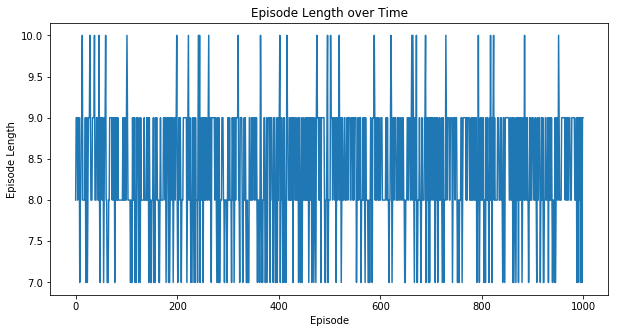

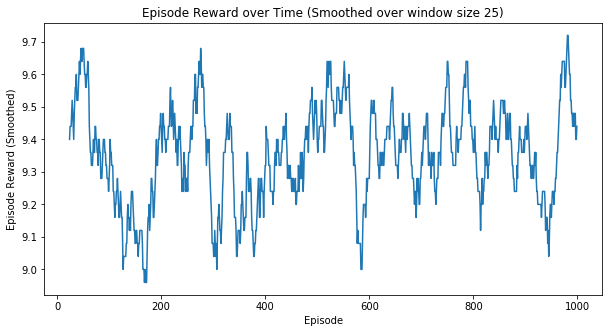

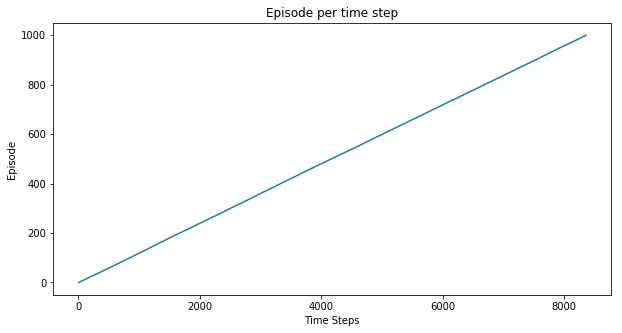

(<matplotlib.figure.Figure at 0x7fcdddd6df28>,
 <matplotlib.figure.Figure at 0x7fcdddcfea90>)

In [34]:
#plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)